# Importing all Libraries

In [1]:
import cv2 as cv
import tensorflow as tf
from os import listdir
import os
from matplotlib import image
import matplotlib.patches as mpatches
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from PIL import Image

2022-12-06 21:49:39.827145: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 21:49:40.705934: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sashankk/miniconda3/envs/vortexdetect/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-06 21:49:40.705988: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-06 21:49:40.795899: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS w

# HOUGH Circle Detection

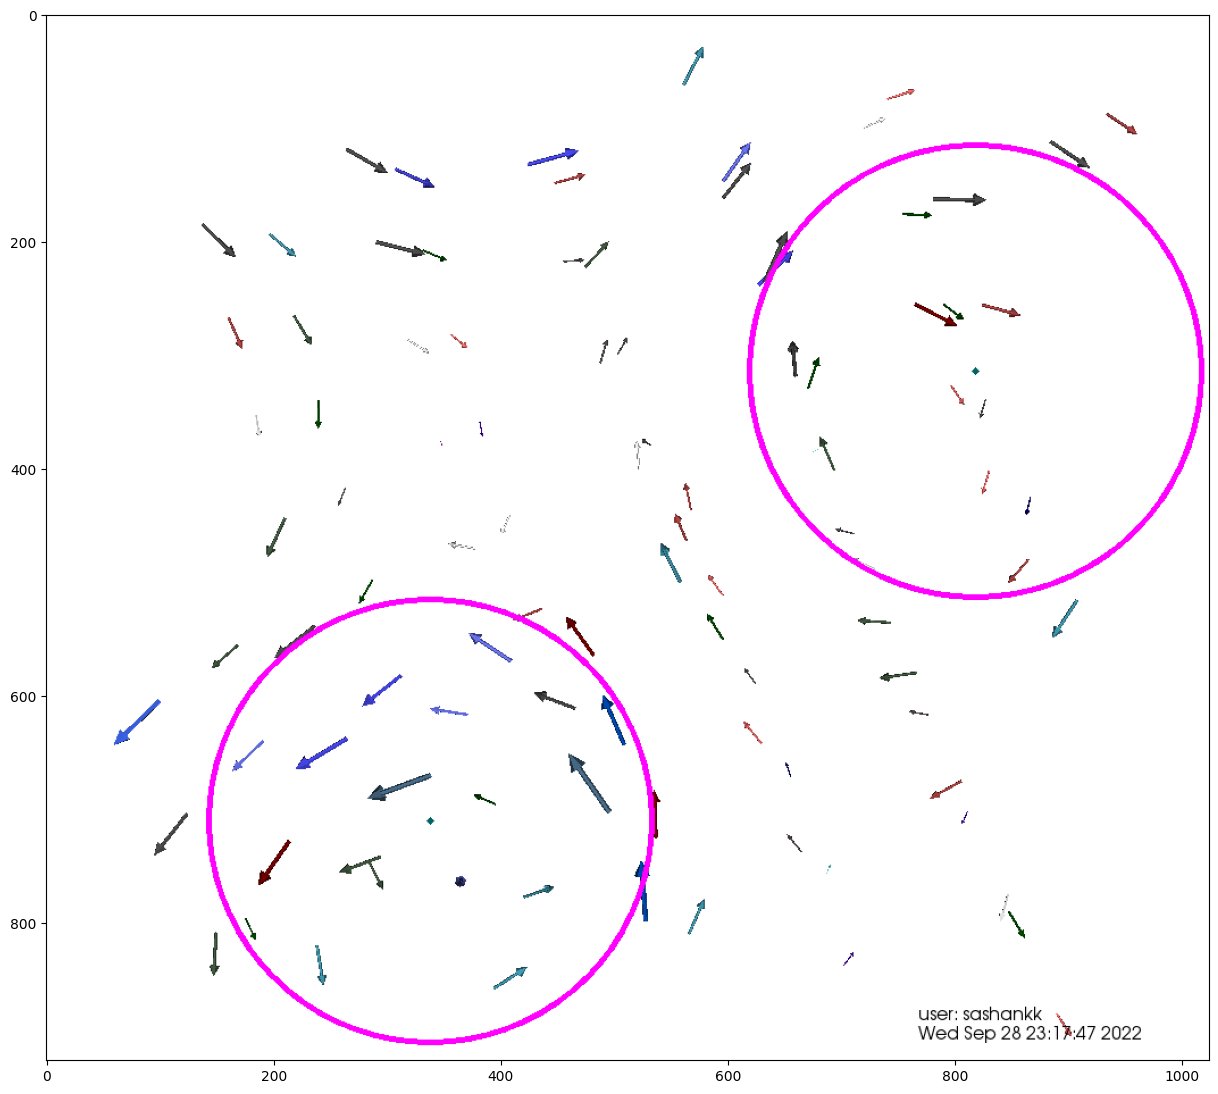

In [2]:
img=cv.imread('/home/sashankk/Proj/MAGNETOHYDRODYNAMIC-TURBULENCE-master/maxhmaxr/visit0008.png')
img1=cv.imread('/home/sashankk/Proj/MAGNETOHYDRODYNAMIC-TURBULENCE-master/maxhmaxr1/visit0008.png')
img_x = img1.copy()

gray=cv.cvtColor(img,cv.COLOR_BGR2GRAY)
blur = cv.GaussianBlur(gray,(9,9),10)

ret,thresh = cv.threshold(blur,127,255,cv.THRESH_TRUNC)

rows = thresh.shape[0]
circles = cv.HoughCircles(thresh, cv.HOUGH_GRADIENT, 1, rows /4, param1=50, param2=50, minRadius=150, maxRadius=200)

all_circles = [] # stores vortex podition and radius

if circles is not None:
    circles = np.uint16(np.around(circles))
    #print(len(circles[0, :]))
    for i in circles[0, :]:
        center = (i[0], i[1])
        # circle center
        cv.circle(img1, center, 1, (0, 100, 100), 3)
            # circle outline
        x, y, r = i[0],i[1],i[2]
        all_circles.append([[x,y],r])
        
        cv.circle(img1, center, r, (255, 0, 255), 3)

plt.figure(figsize = (15,15))
imgplot = plt.imshow(img1)


# Finding Region between the Vortices

818 314 338 710


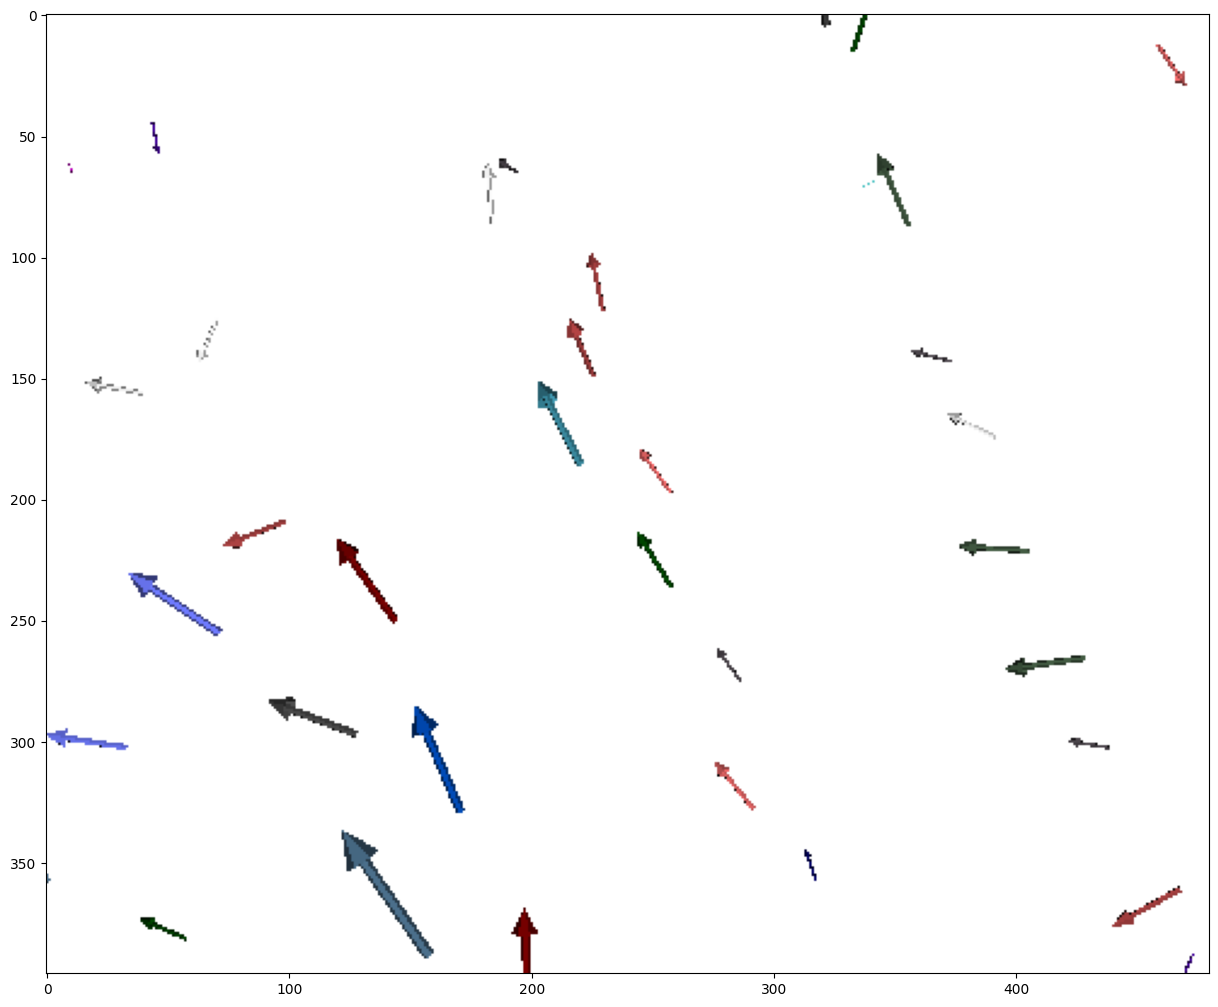

In [3]:
import math
import sys
circle1 = all_circles[0]
circle2 = all_circles[1]

c1 = circle1[0]
c2 = circle2[0]
r1 = circle1[1]`
r2 = circle2[1]
#cdist = math.sqrt((c1[0]-c2[0])**2 + (c1[1]-c2[1])**2)

c1_x = c1[0]
c1_y = c1[1]
c2_y = c2[1]
c2_x = c2[0]
print(c1_x,c1_y,c2_x,c2_y)

# w = int(maxx)-int(minx)
# h = int(maxy)-int(miny)
# slope = math.atan(h/w)*180
# print(w,h,slope)

mx=min(c1_x,c2_x)
Mx=max(c1_x,c2_x)
my=min(c1_y,c2_y)
My=max(c1_y,c2_y)

img_temp = img_x[my:My, mx:Mx]
#rRect = cv.minAreaRect(((minx+maxx)/2, (miny+maxy)/2), (w,h), slope)
#brect = rRect.boundingRect()
cv.rectangle(img1, (c2_x,c2_y), (c1_x, c1_y), (255, 0, 255), 2)
plt.figure(figsize = (15,15))
imgplot = plt.imshow(img_temp)

# Crop All Vectors

In [4]:
def get_objects(image,name):
    
    gray=cv.cvtColor(image,cv.COLOR_BGR2GRAY)

    edged = cv.Canny(image, 10, 250)

    (cnts, _) = cv.findContours(edged.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    dir = "/home/sashankk/Proj/integrate/CNN_Model/Test/"
    
    idx = 0
    for c in cnts:
        x,y,w,h = cv.boundingRect(c)
        if w>15 and h>15:
            idx+=1
            new_img=image[y:y+h,x:x+w]
            #cropping images
            cv.imwrite(dir+name+'_'+str(idx)+ '.png', new_img)
    #cv2.imshow("Original Image",image)
    #cv2.imshow("Canny Edge",edged)


In [5]:
def crop_objects(img):
    height, width = img.shape[0], img.shape[1]
    #print(height,width)
    n1, n2 = ['top','bottom'], ['left','right']

    img1 = img[0:height//2, 0:width//2]
    img2 = img[0:height//2, width//2:width]
    img3 = img[height//2:height, 0:width//2]
    img4 = img[height//2:height, width//2:width]
    image = [img1,img2,img3,img4]

    j, k = 0, 0
    
    # Vectors are cropped as per their positions (top-left or bottom-right or ...)
    for i in range(1,5):
        if k==2:
            j += 1
            k = 0
        #print(j,k)
        name = n1[j]+'_'+n2[k]
        k += 1
        get_objects(image[i-1],name)
    
    #print("Image cropped successful")


# Delete Images from a Directory 

In [6]:
def remove_objects():
    dir = '/home/sashankk/Proj/integrate/CNN_Model/Test/'
    
    for f in os.listdir(dir):
        os.remove(os.path.join(dir, f))


# Test CNN And Detect Direction of Vectors

In [7]:
def prepare(file):
    IMG_SIZE = 80
    img_array = cv.imread(file, cv.IMREAD_GRAYSCALE)
    new_array = cv.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [8]:
def test_results():
    data = []

    for filename in listdir('/home/sashankk/Proj/integrate/CNN_Model/Test/'):
        img_dir = '/home/sashankk/Proj/integrate/CNN_Model/Test/' + filename
        img = prepare(img_dir)
        img_data = Image.open(img_dir)
        prediction = model.predict([img])
        prediction = list(prediction[0])
        name = CATEGORIES[prediction.index(max(prediction))]
        data.append([filename,name])
    
    return data


# Detect The Orientation of Vectors

In [10]:
def detect_rotation(data):
    left,down,up,right = 0, 0, 0, 0
    for i in range(len(data)):
        img_name = data[i][0]
        direction = data[i][1]
        ps = img_name.split("_")
#         position = ps[0]+'-'+ps[1]
        if direction=="left":
            left+=1
        if direction=="right":
            right+=1
        if direction=="up":
            up+=1
        if direction=="down":
            down+=1
    return [left,right,up,down]

In [11]:
def prediction(data):
    left, right, up, down = detect_rotation(data)
    print(left,right,up,down)

    if (left>3 and right>3) or (up>3 and down>3):
        return "No Reconnection Region"
    else:
        return "Reconnection Region"

# Integration

In [12]:
CATEGORIES = ["left","right","up","down"]

model = tf.keras.models.load_model('CNN.model')

2022-12-06 21:54:52.459328: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sashankk/miniconda3/envs/vortexdetect/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-06 21:54:52.459970: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-06 21:54:52.460002: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sashankk-VirtualBox): /proc/driver/nvidia/version does not exist
2022-12-06 21:54:52.461192: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.

In [13]:
crop_objects(img_temp)
    
# Detect and predict the reconnecion region
direction = test_results()
predicted_result = prediction(direction)

1/1 [==============================] - 0s 22ms/step
13 1 11 0


In [14]:
print(predicted_result)   

Reconnection Region
